In [1]:
!ls ../input/tslearn/

tslearn-0.4.1-cp35-cp35m-macosx_10_9_x86_64.whl  tslearn-0.4.1.xyz


In [2]:
!mkdir -p /tmp/pip/cache/

!cp ../input/tslearn/tslearn-0.4.1.xyz /tmp/pip/cache/tslearn-0.4.1.tar.gz
!cp ../input/tslearn/tslearn-0.4.1-cp35-cp35m-macosx_10_9_x86_64.whl /tmp/pip/cache/

In [3]:
!pip install --no-index --find-links /tmp/pip/cache/ tslearn

Looking in links: /tmp/pip/cache/
Processing /tmp/pip/cache/tslearn-0.4.1.tar.gz
  Created wheel for tslearn: filename=tslearn-0.4.1-cp37-cp37m-linux_x86_64.whl size=716728 sha256=c9061715b70ed082a6b90b07cc8f506ad58cbfe85117a9854d842f569149fbac
  Stored in directory: /root/.cache/pip/wheels/0d/15/8f/a9dd17846303774b5994bc23d652c4b09859b82cd01ec6e2f3
Successfully built tslearn


In [4]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import category_encoders as ce
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import lightgbm as lgb
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [6]:
def seed_everything(seed=777):#元は2020
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

In [7]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

In [8]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [9]:
chunk.head(6)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [10]:
sub.Patient.value_counts()

ID00422637202311677017371    146
ID00419637202311204720264    146
ID00423637202312137826377    146
ID00421637202311550012437    146
ID00426637202313170790466    146
Name: Patient, dtype: int64

In [11]:
chunk.Patient.value_counts()

ID00426637202313170790466    1
ID00422637202311677017371    1
ID00421637202311550012437    1
ID00419637202311204720264    1
ID00423637202312137826377    1
Name: Patient, dtype: int64

In [12]:
tr['WHERE'] = 'train'

std_FVC = tr.groupby("Patient").std().reset_index()[["Patient","FVC"]]
std_FVC.columns = ["Patient","FVC_std"]

tr = pd.merge(tr, std_FVC, on='Patient',how="left")

tr["FVC_diff"] = tr.groupby(["Patient"])["FVC"].diff()
tr["Week_diff"] = tr.groupby(["Patient"])["Weeks"].diff()
tr["FVC_change"] = tr["FVC_diff"]/tr["Week_diff"]


tr["FVC_shift_1"] = tr.groupby("Patient")["FVC_change"].shift(-1)
tr["FVC_diff_2"] = tr["FVC_change"]-tr["FVC_shift_1"]

print(f'There are {len(tr[tr.FVC_diff_2 < -250])} liers')

tr.loc[tr.FVC_diff_2 < -250,"FVC"] = tr.groupby("Patient")["FVC"].transform(lambda x:(x.shift(1)+x.shift(-1))/2)
print(f"{len(tr[tr.FVC_diff_2 < -250])*100/len(tr)}% sample were corrected!!!")
tr.drop(["FVC_diff","Week_diff","FVC_change","FVC_shift_1","FVC_diff_2"], axis=1, inplace=True)
# tr = tr[tr.FVC_std < 350]
tr.drop("FVC_std",axis=1, inplace=True)
# print(f"train num after:{len(tr)}")
# reduction_rate = len(tr)*100/num_before
# print (f"{reduction_rate}% remained")
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

There are 17 liers
1.1074918566775245% sample were corrected!!!


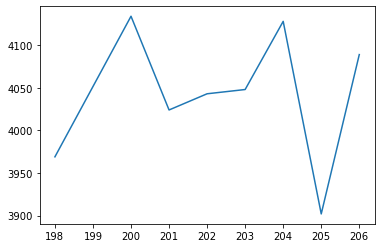

In [13]:
tr.loc[tr.Patient =="ID00061637202188184085559","FVC"].plot()

In [14]:
tr.head(6)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE
0,ID00007637202177411956430,-4,2315.0,58.253649,79,Male,Ex-smoker,train
1,ID00007637202177411956430,5,2214.0,55.712129,79,Male,Ex-smoker,train
2,ID00007637202177411956430,7,2061.0,51.862104,79,Male,Ex-smoker,train
3,ID00007637202177411956430,9,2144.0,53.950679,79,Male,Ex-smoker,train
4,ID00007637202177411956430,11,2069.0,52.063412,79,Male,Ex-smoker,train
5,ID00007637202177411956430,17,2101.0,52.868646,79,Male,Ex-smoker,train


In [15]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [16]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [17]:
tr.head(6)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE
0,ID00007637202177411956430,-4,2315.0,58.253649,79,Male,Ex-smoker,train
1,ID00007637202177411956430,5,2214.0,55.712129,79,Male,Ex-smoker,train
2,ID00007637202177411956430,7,2061.0,51.862104,79,Male,Ex-smoker,train
3,ID00007637202177411956430,9,2144.0,53.950679,79,Male,Ex-smoker,train
4,ID00007637202177411956430,11,2069.0,52.063412,79,Male,Ex-smoker,train
5,ID00007637202177411956430,17,2101.0,52.868646,79,Male,Ex-smoker,train


In [18]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [19]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#=================

In [20]:
data["FVC_per_smoking"] = data.groupby("SmokingStatus")["FVC"].transform("mean")
data["FVC_per_sex_smoking"] = data.groupby(["SmokingStatus","Sex"])["FVC"].transform("mean")
data["FVC_std_per_sex_smoking"] = data.groupby(["SmokingStatus","Sex"])["FVC"].transform("std")

data["FVC_per_smoking"] =(data["FVC_per_smoking"]-data["FVC_per_smoking"].min())/(data["FVC_per_smoking"].max()-data["FVC_per_smoking"].min())
data["FVC_per_sex_smoking"] =(data["FVC_per_sex_smoking"]-data["FVC_per_sex_smoking"].min())/(data["FVC_per_sex_smoking"].max()-data["FVC_per_sex_smoking"].min())
data["FVC_std_per_sex_smoking"] =(data["FVC_std_per_sex_smoking"]-data["FVC_std_per_sex_smoking"].min())/(data["FVC_std_per_sex_smoking"].max()-data["FVC_std_per_sex_smoking"].min())

FE += ['FVC_per_smoking','FVC_per_sex_smoking','FVC_std_per_sex_smoking']

#=================
percent_data = data["Percent"]
percent_tr = tr["Percent"]
percent_sub = sub["Percent"]

aux = data[['Patient', 'Weeks', 'Percent']].sort_values(by=['Patient', 'Weeks'])
aux = aux.groupby('Patient').head(1)
aux = aux.rename(columns={'Percent': 'Percent_base'})
data = pd.merge(data, aux[['Patient', 'Percent_base']], how='left',on='Patient')
aux = data[['Patient', 'Weeks', 'Age']].sort_values(by=['Patient', 'Weeks'])
aux = aux.groupby('Patient').head(1)
aux = aux.rename(columns={'Age': 'base_Age'})
data = pd.merge(data, aux[['Patient', 'base_Age']], how='left',on='Patient')

# data["Percent"] = percent_data

data["typical_FVC"] = data["min_FVC"] * 100 / data["Percent_base"]


typical_Sex = data.groupby("Sex").mean().reset_index()[["Sex","typical_FVC"]]
typical_Sex.columns = ["Sex","typical_Sex"]
typical_Smoking = data.groupby("SmokingStatus").mean().reset_index()[["SmokingStatus","typical_FVC"]]
typical_Smoking.columns = ["SmokingStatus","typical_Smoking"]
data = pd.merge(data,typical_Sex, on="Sex", how="left" )
data = pd.merge(data,typical_Smoking, on="SmokingStatus", how="left")
# typical_Age = data.groupby("base_Age").mean().reset_index()[["base_Age","typical_FVC"]]
# typical_Age.columns = ["base_Age","typical_Age"]
# data = pd.merge(data,typical_Age, on="base_Age", how="left" )



data["typical_Sex"] = (data["typical_Sex"]-data["typical_Sex"].min())/(data["typical_Sex"].max()-data["typical_Sex"].min())
data["typical_Smoking"] = (data["typical_Smoking"]-data["typical_Smoking"].min())/(data["typical_Smoking"].max()-data["typical_Smoking"].min())
# data["typical_Age"] = (data["typical_Age"]-data["typical_Age"].min())/(data["typical_Age"].max()-data["typical_Age"].min())

data["typical_FVC"] = (data["typical_FVC"]-data["typical_FVC"].min())/(data["typical_FVC"].max()-data["typical_FVC"].min())
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['Percent_base'] = (data['Percent_base'] - data['Percent_base'].min() ) / ( data['Percent_base'].max() - data['Percent_base'].min() )
FE += ['age','Percent_base','week','BASE',"typical_FVC","typical_Sex","typical_Smoking"]
# FE += ['age','Percent','week','BASE']

In [21]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [22]:
tr.shape, chunk.shape, sub.shape

((1535, 29), (5, 29), (730, 29))

In [23]:
sub.head(6)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,Percent_base,base_Age,typical_FVC,typical_Sex,typical_Smoking,age,BASE,week
1540,ID00419637202311204720264,-12,3020.0,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,6.0,3020.0,-18.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.067901
1541,ID00419637202311204720264,-11,3020.0,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,6.0,3020.0,-17.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.074074
1542,ID00419637202311204720264,-10,3020.0,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,6.0,3020.0,-16.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.080247
1543,ID00419637202311204720264,-9,3020.0,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,6.0,3020.0,-15.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.086420
1544,ID00419637202311204720264,-8,3020.0,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,6.0,3020.0,-14.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.092593
1545,ID00419637202311204720264,-7,3020.0,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-7,6.0,3020.0,-13.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.098765


In [24]:
# conda install -c conda-forge tslearn

In [25]:
# ! pip install tslearn

In [26]:
week_max = tr.Weeks.max()
week_min = tr.Weeks.min()
week_col = [week for week in np.arange(week_min, week_max)]

grid = pd.DataFrame(columns = week_col, index=tr.Patient.unique())

for patient in tr.Patient.unique():
    temp_df = tr[tr.Patient == patient].set_index("Weeks")
    min_FVC_ = temp_df.reset_index().min_FVC[0]
    all_weeks = tr[tr.Patient==patient].Weeks.unique()
    for week in week_col:
        if week in all_weeks:
            grid.loc[patient, week] = temp_df.loc[week,"FVC"]
            min_FVC_ = temp_df.loc[week,"FVC"]
        else:
            grid.loc[patient,week] = min_FVC_
        
grid.head(5)                     

,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132
ID00007637202177411956430,2315,2315,2315,2315,2315,2315,2315,2315,2315,2315,2214,2214,2061,2061,2144,2144,2069,2069,2069,2069,2069,2069,2101,2101,2101,2101,2101,2101,2101,2101,2101,2101,2101,2101,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057
ID00009637202177434476278,3660,3660,3660,3660,3660,3660,3660,3660,3660,3660,3660,3660,3660,3660,3610,3610,3895,3895,3759,3759,3639,3639,3639,3639,3639,3639,3639,3578,3578,3578,3578,3578,3578,3578,3578,3578,3578,3578,3625,3625,3625,3625,3625,3625,3625,3625,3625,3625,3625,3625,3390,3390,3390,3390,3390,3390,3390,3390,3390,3390,3390,3390,3390,3390,3390,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214,3214
ID00010637202177584971671,3523,3523,3523,3523,3523,3523,3373,3373,3327,3327,2993,2993,3030,3030,3030,3030,3030,3030,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,3103,2993,2993,2993,2993,2993,2993,2993,2993,2993,2993,2993,2993,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2474,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518
ID00011637202177653955184,3326,3326,3326,3326,3326,3326,3326,3326,3326,3326,3326,3326,3419,3419,3541,3541,3502,3502,3410,3410,3410,3410,3410,3410,3477,3477,3477,3477,3477,3477,3477,3477,3477,3477,3477,3477,3477,3269,3269,3269,3269,3269,3269,3269,3269,3269,3269,3269,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193,3193
ID00012637202177665765362,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3418,3759,3759,3601,3601,3443,3443,3268,3268,3268,3268,3268,3268,3449,3449,3449,3449,3449,3449,3449,3449,3449,3449,3449,3324,3324,3324,3324,3324,3324,3324,3324,3324,3324,3324,3324,3324,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,3231,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,2971,29

0.079 --> 0.075 --> 0.074 --> 0.073 --> 0.073 --> 0.073 --> 0.073 --> 0.073 --> 


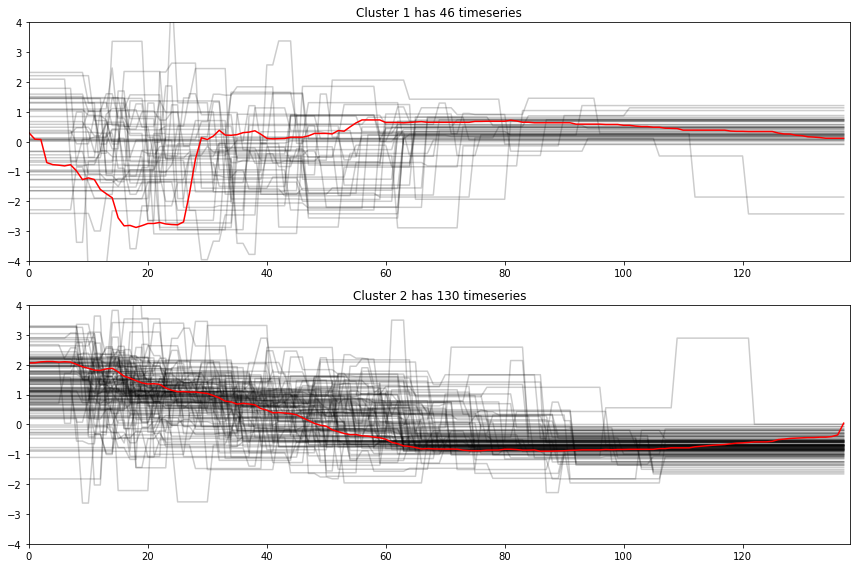

In [27]:
grid_value = grid.values
nc = 2
seed=8

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(grid_value)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=nc, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(12,nc*4))
for yi in range(nc):
    plt.subplot(nc, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries") 

plt.tight_layout()
plt.show()

In [28]:
clus_df = pd.DataFrame({"Patient":grid.index, "cluster":y_pred})
tr = pd.merge(tr, clus_df, on="Patient", how="left")

In [29]:
print(len(tr[tr.cluster == 0]))
print(len(tr[tr.cluster==1]))
print(len(tr[tr.cluster==2]))

403
1132
0


Cluster:0
Cluster:1


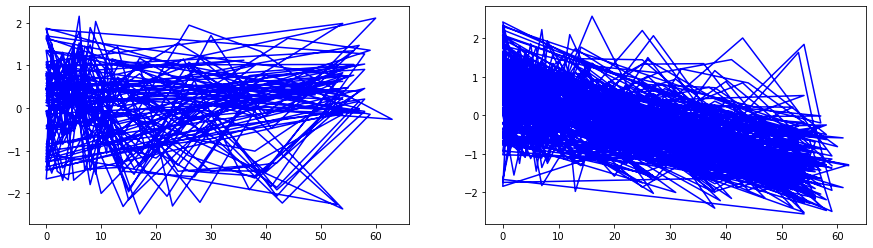

In [30]:
tr["FVC_mean"] = tr.groupby("Patient")["FVC"].transform("mean")
tr["FVC_std"] = tr.groupby("Patient")["FVC"].transform("std")

tr["FVC_scaled"] = (tr["FVC"]-tr["FVC_mean"])/tr["FVC_std"]


plt.figure(figsize=(15,4))
print(f"Cluster:0")
plt.subplot(1,2,1)
plt.plot(tr[tr.cluster==0].base_week, tr[tr.cluster==0].FVC_scaled,color="blue")
# plt.plot(items_per_day.day, items_per_day.wb_items, marker="o", color="red")

plt.subplot(1,2,2)
print(f"Cluster:1")
plt.plot(tr[tr.cluster==1].base_week, tr[tr.cluster==1].FVC_scaled,color="blue")           

# plt.subplot(1,3,3)
# print(f"Cluster:2")
# plt.plot(tr[tr.cluster==2].base_week, tr[tr.cluster==2].FVC_scaled,color="blue")   
tr.drop(["FVC_mean","FVC_std","FVC_scaled"],axis=1, inplace=True)

In [31]:
sub.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'WHERE', 'Confidence', 'Patient_Week', 'min_week', 'min_FVC',
       'base_week', 'Male', 'Female', 'Ex-smoker', 'Never smoked',
       'Currently smokes', 'FVC_per_smoking', 'FVC_per_sex_smoking',
       'FVC_std_per_sex_smoking', 'Percent_base', 'base_Age', 'typical_FVC',
       'typical_Sex', 'typical_Smoking', 'age', 'BASE', 'week'],
      dtype='object')

In [32]:
tr.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'WHERE', 'Confidence', 'Patient_Week', 'min_week', 'min_FVC',
       'base_week', 'Male', 'Female', 'Ex-smoker', 'Never smoked',
       'Currently smokes', 'FVC_per_smoking', 'FVC_per_sex_smoking',
       'FVC_std_per_sex_smoking', 'Percent_base', 'base_Age', 'typical_FVC',
       'typical_Sex', 'typical_Smoking', 'age', 'BASE', 'week', 'cluster'],
      dtype='object')

In [33]:
TARGET="FVC"
ID = 'Patient_Week'
target = tr["FVC"]
sub["FVC"] = np.nan


# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in sub.columns if (sub.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week']
features = [c for c in features if c not in drop_features]
num_round = 10000

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    tr_enc = tr.drop("cluster", axis=1)
    ce_oe.fit(tr_enc)
    train = ce_oe.transform(tr_enc)
    test = ce_oe.transform(sub)
        

In [34]:
features = ["week","BASE","Percent_base","base_Age","SmokingStatus","Sex",'FVC_per_smoking','FVC_per_sex_smoking','FVC_std_per_sex_smoking']
features += ["typical_FVC","typical_Sex","typical_Smoking"]
NFOLD_lgb = 4
Fold_lgb = GroupKFold(n_splits=NFOLD_lgb)
folds_lgb = tr[["Patient","week","FVC"]].copy()
groups = folds_lgb["Patient"].values
for n, (tr_idx,va_idx) in enumerate(Fold_lgb.split(folds_lgb, folds_lgb["FVC"],groups)):
    folds_lgb.loc[va_idx,"fold"] = int(n)
folds_lgb["fold"] = folds_lgb["fold"].astype(int)
target_clus = tr["cluster"]

rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1,max_depth=10, random_state=0,n_estimators=100)
oof_rf = np.zeros((len(train),2))
prediction_rf = np.zeros((len(test),2))
for fold_ in range(NFOLD_lgb):
    tr_idx, va_idx = folds_lgb[folds_lgb.fold!=fold_].index, folds_lgb[folds_lgb.fold == fold_].index
    tr_df = train.iloc[tr_idx][features]
    va_df = train.iloc[va_idx][features]
    rf_model.fit(tr_df,target_clus[tr_idx])
    oof_rf[va_idx] = rf_model.predict_proba(va_df)
    prediction_rf += rf_model.predict_proba(test[features])/NFOLD_lgb

In [35]:
(pred_rf == 1)

NameError: name 'pred_rf' is not defined

In [36]:
pred_rf = []
pred_rf_test = []
for x in oof_rf:
    pe_rf = x[1] > 0.60
    pred_rf.append(pe_rf.astype(int))

# tr["pred_rf"] = pred_rf == 1
tr["pred_rf"] = pred_rf
tr["pred_rf"] = tr["pred_rf"].astype(int)
train["pred_rf"] = pred_rf
for x in prediction_rf:
#     pred_rf_test.append(np.argmax(x))
    pe_rf = x[1] > 0.60
    pred_rf_test.append(pe_rf.astype(int))

# sub["pred_rf"] = pred_rf_test == 1
sub["pred_rf"] = pred_rf_test
sub["pred_rf"] = sub["pred_rf"].astype(int)
test["pred_rf"] = pred_rf_test

cat_features.append("pred_rf")
FE += ["pred_rf"]

### BASELINE NN 

In [37]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [38]:
#===========================================================
# model
#===========================================================
SEED = 42
OUTPUT_DICT = './'
def run_single_lightgbm(param, train_df, test_df, folds, features, target, fold_num=0, categorical=[],num_round=400):
    
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                               label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx])
    else:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical)

    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))

    num_round = num_round

    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,
#                     early_stopping_rounds=100,
                   )

    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=num_round)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_num

#     predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=num_round)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(fold_num, np.sqrt(mean_absolute_error(target[val_idx], oof[val_idx]))))
    
    return oof, predictions, fold_importance_df


def run_kfold_lightgbm(param, train, test, folds, features, target, n_fold=5, categorical=[],num_round=400):
    
    logger.info(f"================================= {n_fold}fold lightgbm =================================")
#     print(f'{n_fold}fold lightgbm')
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df = run_single_lightgbm(param,
                                                                     train,
                                                                     test,
                                                                     folds,
                                                                     features,
                                                                     target,
                                                                     fold_num=fold_,
                                                                     categorical=categorical,
                                                                     num_round = num_round,
                                                                    )
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(np.sqrt(mean_absolute_error(target, oof))))

    logger.info(f"=========================================================================================")
    
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    #plt.figure(figsize=(8, 16))
    plt.figure(figsize=(6, 4))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')
    
    
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

In [39]:
tr["Male"].dtype

dtype('int64')

In [40]:
features_nn = [col for col in FE if "FVC" not in col]
# features_nn.append("typical_FVC")
print(features_nn)
y = tr['FVC'].values
tr["pred_rf"] = tr["pred_rf"].astype(np.int64)
sub["pred_rf"] = sub["pred_rf"].astype(np.int64)
z = tr[features_nn].values
z_stable = tr[tr.pred_rf == 0].values
stable_index = tr[tr.pred_rf == 0].index
z_dec = tr[tr.pred_rf == 1].values
dec_index = tr[tr.pred_rf == 1].index
ze = sub[features_nn].values
ze_stable = sub[sub.pred_rf == 1].values
ze_dec = sub[sub.pred_rf==1]
nh = z.shape[1]
pred = np.zeros((z.shape[0], 3))
pred_stable = np.zeros((z_stable.shape[0],3))
pred_dec = np.zeros((z_dec.shape[0],3))
pe = np.zeros((ze.shape[0], 3))
pe_stable = np.zeros((ze_stable.shape[0],3))
pe_dec = np.zeros((ze_dec.shape[0],3))

['Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes', 'age', 'Percent_base', 'week', 'BASE', 'typical_Sex', 'typical_Smoking', 'pred_rf']


In [41]:
FE

['Male',
 'Female',
 'Ex-smoker',
 'Never smoked',
 'Currently smokes',
 'FVC_per_smoking',
 'FVC_per_sex_smoking',
 'FVC_std_per_sex_smoking',
 'age',
 'Percent_base',
 'week',
 'BASE',
 'typical_FVC',
 'typical_Sex',
 'typical_Smoking',
 'pred_rf']

In [42]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1300        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [43]:
NFOLD = 6
kf = KFold(n_splits=NFOLD)

Fold = GroupKFold(n_splits=NFOLD)
folds = tr[["Patient","week","FVC"]].copy()
groups = folds["Patient"].values
for n, (tr_idx,va_idx) in enumerate(Fold.split(folds, folds["FVC"],groups)):
    folds.loc[va_idx,"fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)

In [44]:
tr.head(6)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,Percent_base,base_Age,typical_FVC,typical_Sex,typical_Smoking,age,BASE,week,cluster,pred_rf
0,ID00007637202177411956430,-4,2315.0,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,0.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.179012,1,0
1,ID00007637202177411956430,5,2214.0,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,9.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.234568,1,0
2,ID00007637202177411956430,7,2061.0,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,11.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.246914,1,0
3,ID00007637202177411956430,9,2144.0,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,13.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.259259,1,0
4,ID00007637202177411956430,11,2069.0,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,15.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.271605,1,0
5,ID00007637202177411956430,17,2101.0,52.868646,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,21.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.308642,1,0


In [45]:
%%time
cnt = 0
EPOCHS = 800

# for tr_idx, val_idx in kf.split(z):
#     cnt += 1
#     print(f"FOLD {cnt}")
#     net = make_model(nh)
#     net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
#             validation_data=(z[val_idx], y[val_idx]), verbose=0) #
#     print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
#     print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
#     print("predict val...")
#     pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
#     print("predict test...")
#     pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
# ==============



for fold_ in range(NFOLD):
    tr_idx, va_idx = folds[folds.fold != fold_].index, folds[folds.fold == fold_].index
    print(f'{fold_} fold')
    net = make_model(nh)
    print(f'num of tr_data:{len(z[tr_idx])}')
    print(f'num of va_data:{len(z[va_idx])}')
    net.fit(z[tr_idx],y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(z[va_idx],y[va_idx]), verbose=0)
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[va_idx], y[va_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[va_idx] = net.predict(z[va_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD


0 fold
num of tr_data:1275
num of va_data:260
train [38.9339485168457, 6.56234884262085]
val [44.55441665649414, 6.761744022369385]
predict val...
predict test...
1 fold
num of tr_data:1281
num of va_data:254
train [41.36383056640625, 6.796765327453613]
val [43.547767639160156, 6.734590530395508]
predict val...
predict test...
2 fold
num of tr_data:1281
num of va_data:254
train [39.7654914855957, 6.6048264503479]
val [47.89305877685547, 6.794793128967285]
predict val...
predict test...
3 fold
num of tr_data:1281
num of va_data:254
train [41.261802673339844, 6.6582865715026855]
val [39.26735305786133, 6.6434245109558105]
predict val...
predict test...
4 fold
num of tr_data:1281
num of va_data:254
train [41.52632141113281, 6.623739242553711]
val [42.90201950073242, 6.699209690093994]
predict val...
predict test...
5 fold
num of tr_data:1276
num of va_data:259
train [39.41069030761719, 6.583077907562256]
val [46.516265869140625, 6.630613327026367]
predict val...
predict test...
CPU times:

In [46]:
print(features)
print("===============")
print(FE)

['week', 'BASE', 'Percent_base', 'base_Age', 'SmokingStatus', 'Sex', 'FVC_per_smoking', 'FVC_per_sex_smoking', 'FVC_std_per_sex_smoking', 'typical_FVC', 'typical_Sex', 'typical_Smoking']
['Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes', 'FVC_per_smoking', 'FVC_per_sex_smoking', 'FVC_std_per_sex_smoking', 'age', 'Percent_base', 'week', 'BASE', 'typical_FVC', 'typical_Sex', 'typical_Smoking', 'pred_rf']


In [47]:
train.head(5)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,Percent_base,base_Age,typical_FVC,typical_Sex,typical_Smoking,age,BASE,week,pred_rf
0,ID00007637202177411956430,-4,2315.0,58.253649,79,1,1,train,NaN,NaN,-4.0,2315.0,0.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.179012,0
1,ID00007637202177411956430,5,2214.0,55.712129,79,1,1,train,NaN,NaN,-4.0,2315.0,9.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.234568,0
2,ID00007637202177411956430,7,2061.0,51.862104,79,1,1,train,NaN,NaN,-4.0,2315.0,11.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.246914,0
3,ID00007637202177411956430,9,2144.0,53.950679,79,1,1,train,NaN,NaN,-4.0,2315.0,13.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.259259,0
4,ID00007637202177411956430,11,2069.0,52.063412,79,1,1,train,NaN,NaN,-4.0,2315.0,15.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.135886,79,0.714466,1.0,1.0,0.769231,0.241456,0.271605,0


================================= 4fold lightgbm =================================
len(trn_idx) : 1151
len(val_idx) : 384
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Fold 0
[100]	training's rmse: 351.414	valid_1's rmse: 362.639
[200]	training's rmse: 203.499	valid_1's rmse: 246.75
[300]	training's rmse: 161.421	valid_1's rmse: 237.158


fold0 RMSE score: 13.16798
len(trn_idx) : 1151
len(val_idx) : 384


[400]	training's rmse: 144.749	valid_1's rmse: 237.623
Fold 1


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's rmse: 337.985	valid_1's rmse: 483.83
[200]	training's rmse: 180.669	valid_1's rmse: 377.584
[300]	training's rmse: 135.163	valid_1's rmse: 345.393


fold1 RMSE score: 14.49426
len(trn_idx) : 1151
len(val_idx) : 384


[400]	training's rmse: 120.536	valid_1's rmse: 336.12
Fold 2


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's rmse: 349.852	valid_1's rmse: 347.48
[200]	training's rmse: 199	valid_1's rmse: 242.669


fold2 RMSE score: 13.54612
len(trn_idx) : 1152
len(val_idx) : 383


[300]	training's rmse: 154.876	valid_1's rmse: 250.377
[400]	training's rmse: 135.439	valid_1's rmse: 266.681
Fold 3


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's rmse: 365.605	valid_1's rmse: 308.206
[200]	training's rmse: 207.925	valid_1's rmse: 206.727


fold3 RMSE score: 12.06867
CV RMSE score: 13.34835


[300]	training's rmse: 161.576	valid_1's rmse: 197.161
[400]	training's rmse: 142.788	valid_1's rmse: 201.06


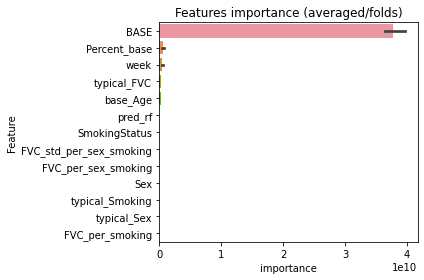

In [48]:
features = ["week","BASE","Percent_base","base_Age","SmokingStatus","Sex",'FVC_per_smoking','FVC_per_sex_smoking','FVC_std_per_sex_smoking',"pred_rf","typical_FVC"]
features += ["typical_Sex","typical_Smoking"]
NFOLD_lgb = 4
Fold_lgb = GroupKFold(n_splits=NFOLD_lgb)
folds_lgb = tr[["Patient","week","FVC"]].copy()
groups = folds["Patient"].values
for n, (tr_idx,va_idx) in enumerate(Fold_lgb.split(folds_lgb, folds_lgb["FVC"],groups)):
    folds_lgb.loc[va_idx,"fold"] = int(n)
folds_lgb["fold"] = folds_lgb["fold"].astype(int)
feature_importance_df, predictions, oof = run_kfold_lightgbm(lgb_param, train[features], test[features], folds_lgb,features, target, 
                                                             n_fold=NFOLD_lgb, categorical = cat_features,num_round=400)
    
show_feature_importance(feature_importance_df, TARGET)

In [49]:
k=7
pe_knr = np.zeros((ze.shape[0], 1))
pred_knr = np.zeros((z.shape[0], 1))
z_knn = tr[FE].values
ze_knn = sub[FE].values


for fold_ in range(NFOLD):
    tr_idx, va_idx = folds[folds.fold != fold_].index, folds[folds.fold == fold_].index
    print(f'{fold_} fold')
    knr = KNeighborsRegressor(n_neighbors=k)
    print(f'num of tr_data:{len(z_knn[tr_idx])}')
    print(f'num of va_data:{len(z_knn[va_idx])}')
    knr.fit(z_knn[tr_idx], y[tr_idx])
#     print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
#     print("val", net.evaluate(z[va_idx], y[va_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred_knr[va_idx] = knr.predict(z_knn[va_idx]).reshape([-1,1])
    print("predict test...")
    pe_knr += knr.predict(ze_knn).reshape([-1,1]) / NFOLD


0 fold
num of tr_data:1275
num of va_data:260
predict val...
predict test...
1 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
2 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
3 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
4 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
5 fold
num of tr_data:1276
num of va_data:259
predict val...
predict test...


In [50]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

152.74188713545908 255.49036598826854


In [51]:
sub[FE].head(5)

,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,age,Percent_base,week,BASE,typical_FVC,typical_Sex,typical_Smoking,pred_rf
1540,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.067901,0.3724,0.813374,1.0,1.0,1
1541,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.074074,0.3724,0.813374,1.0,1.0,1
1542,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.080247,0.3724,0.813374,1.0,1.0,1
1543,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.086420,0.3724,0.813374,1.0,1.0,1
1544,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.092593,0.3724,0.813374,1.0,1.0,1


In [52]:
train_x_2 = pd.DataFrame({"pred_1a":pred[:,1],"pred_1b":oof, "pred_1c":np.concatenate(pred_knr)})

train_x_2_new = pd.concat([train_x_2,tr[FE].reset_index()], axis=1)
test_x_2 = pd.DataFrame({"pred_1a":pe[:,1],"pred_1b":predictions, "pred_1c":np.concatenate(pe_knr)})
test_x_2_new = pd.concat([test_x_2,sub[FE].reset_index()], axis=1)

train_x_2_new.drop("index", axis=1,inplace=True)
test_x_2_new.drop("index",axis=1, inplace=True)

from sklearn.linear_model import LinearRegression
model_2 = LinearRegression()
# model_2 = Ridge(alpha=1.0)
pe_linear = np.zeros((ze.shape[0], 1))
pred_linear = np.zeros((z.shape[0], 1))
pe_linear_new = np.zeros((ze.shape[0], 1))
pred_linear_new = np.zeros((z.shape[0], 1))
for fold_ in range(NFOLD):
    tr_idx, va_idx = folds[folds.fold != fold_].index, folds[folds.fold == fold_].index
    print(f'{fold_} fold')
    print(f'num of tr_data:{len(train_x_2.loc[tr_idx])}')
    print(f'num of va_data:{len(train_x_2.loc[va_idx])}')
    model_2.fit(train_x_2.loc[tr_idx].values,y[tr_idx])
    print("predict val...")
    pred_linear[va_idx] = model_2.predict(train_x_2.loc[va_idx].values).reshape([-1,1])
    print("predict test...")
    pe_linear += model_2.predict(test_x_2.values).reshape([-1,1]) / NFOLD
    
for fold_ in range(NFOLD):
    tr_idx, va_idx = folds[folds.fold != fold_].index, folds[folds.fold == fold_].index
    print(f'{fold_} fold')
    print(f'num of tr_data:{len(train_x_2.loc[tr_idx])}')
    print(f'num of va_data:{len(train_x_2.loc[va_idx])}')
    model_2.fit(train_x_2_new.loc[tr_idx].values,y[tr_idx])
    print("predict val...")
    pred_linear_new[va_idx] = model_2.predict(train_x_2_new.loc[va_idx].values).reshape([-1,1])
    print("predict test...")
    pe_linear_new += model_2.predict(test_x_2_new.values).reshape([-1,1]) / NFOLD
    


# pred_train_2_ave, pred_test_2_ave = (pred[:,1] + oof)/2, (pe[:,1] + predictions)/2

0 fold
num of tr_data:1275
num of va_data:260
predict val...
predict test...
1 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
2 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
3 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
4 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
5 fold
num of tr_data:1276
num of va_data:259
predict val...
predict test...
0 fold
num of tr_data:1275
num of va_data:260
predict val...
predict test...
1 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
2 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
3 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
4 fold
num of tr_data:1281
num of va_data:254
predict val...
predict test...
5 fold
num of tr_data:1276
num of va_data:259
predict val...
predict test...


In [53]:
pred_train_2_ave, pred_test_2_ave = pred[:,1]*0.8 + oof*0.2, pe[:,1]*0.8 + predictions*0.2

In [54]:
# tr["FVC_pred"] = pred_linear_new
tr["FVC_pred"] = pred_train_2_ave

In [55]:
train_x_2_new.head(20)

,pred_1a,pred_1b,pred_1c,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,age,Percent_base,week,BASE,typical_FVC,typical_Sex,typical_Smoking,pred_rf
0,2330.042480,2329.085112,2389.000000,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.179012,0.241456,0.714466,1.0,1.0,0
1,2298.786865,2312.860681,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.234568,0.241456,0.714466,1.0,1.0,0
2,2292.128418,2292.416121,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.246914,0.241456,0.714466,1.0,1.0,0
3,2285.470215,2294.514530,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.259259,0.241456,0.714466,1.0,1.0,0
4,2278.811279,2285.662293,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.271605,0.241456,0.714466,1.0,1.0,0
5,2259.188232,2270.612683,2384.857143,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.308642,0.241456,0.714466,1.0,1.0,0
6,2229.238770,2188.798962,2277.857143,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.382716,0.241456,0.714466,1.0,1.0,0
7,2209.399902,2120.313245,2111.142857,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.456790,0.241456,0.714466,1.0,1.0,0
8,2188.751953,2134.440657,2078.714286,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.555556,0.241456,0.714466,1.0,1.0,0
9,3640.156006,3563.995452,3418.571429,1,0,1,0,0,0.368718,0.686298,0.986459,0.512821,0.382367,0.179012,0.491270,0.810005,1.0,1.0,1


In [56]:
len(test_x_2_new.pred_1b.value_counts())

223

In [57]:
sigma_opt_ens = mean_absolute_error(y, pred_linear_new)
sigma_opt_ave = mean_absolute_error(y, pred_train_2_ave)
sigma_opt_lgb = mean_absolute_error(y, oof)
sigma_opt_knn = mean_absolute_error(y, pred_knr)

print(f'oof error in lgb:{sigma_opt_lgb}')
print(f'oof error in ens:{sigma_opt_ens}')
print(f'oof error in simple average:{sigma_opt_ave}')
print(f'oof error in knn:{sigma_opt_knn}')

oof error in lgb:178.1785039206169
oof error in ens:150.00451549415374
oof error in simple average:149.85148618855598
oof error in knn:277.97184737087014


In [58]:
import scipy as sp
import math
from functools import partial

def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(tr.iterrows(), total=len(tr))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]
    #bounds = [(70, 100)]
    #result = sp.optimize.minimize(loss_partial, weight, method='SLSQP', bounds=bounds)
    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])

100%|██████████| 1535/1535 [00:04<00:00, 321.93it/s]


In [59]:
# optimized score
tr['Confidence_lgb'] = results
tr['sigma_clipped_lgb'] = tr['Confidence_lgb'].apply(lambda x: max(x, 70))
tr['diff'] = abs(tr['FVC'] - tr['FVC_pred'])
tr['delta'] = tr['diff'].apply(lambda x: min(x, 1000))
tr['score_lgb'] = -math.sqrt(2)*tr['delta']/tr['sigma_clipped_lgb'] - np.log(math.sqrt(2)*tr['sigma_clipped_lgb'])
score = tr['score_lgb'].mean()
print(f'optimized score:{score}')

optimized score:-6.273291758775165


================================= 4fold lightgbm =================================
len(trn_idx) : 1151
len(val_idx) : 384
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
fold0 RMSE score: 12.21093
len(trn_idx) : 1151
len(val_idx) : 384
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Fold 0
[100]	training's rmse: 167.942	valid_1's rmse: 214.857
Fold 1


fold1 RMSE score: 12.18450
len(trn_idx) : 1151
len(val_idx) : 384
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
fold2 RMSE score: 12.36957


[100]	training's rmse: 164.216	valid_1's rmse: 224.167
Fold 2
[100]	training's rmse: 165.506	valid_1's rmse: 216.477
Fold 3


len(trn_idx) : 1152
len(val_idx) : 383
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
fold3 RMSE score: 11.39231
CV RMSE score: 12.04574


[100]	training's rmse: 182.357	valid_1's rmse: 164.619


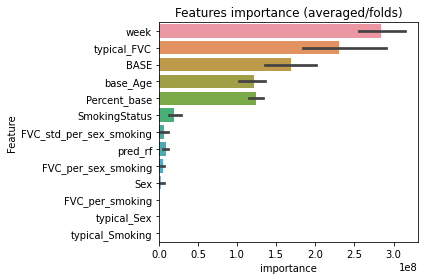

In [60]:
TARGET = 'Confidence_lgb'

target = tr[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus',"pred_rf"]
# num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
# features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'FVC', 'FVC_pred']
features = [c for c in features if c not in drop_features]

lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

feature_importance_df, conf_predictions, conf_oof = run_kfold_lightgbm(lgb_param, train[features], test[features], folds_lgb, features, target, 
                                                             n_fold=NFOLD_lgb, categorical=cat_features,num_round=100)
    
show_feature_importance(feature_importance_df, TARGET)

In [61]:
unc = 0.5* (pred[:,2]-pred[:,0]) + 0.5 * conf_oof

In [62]:
def lb_metric(train):
    train['Confidence'] = unc
    train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
    train['diff'] = abs(train['FVC']-train["FVC_pred"])
    train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
    train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
    score = train['score'].mean()
    return score

score = lb_metric(tr)
print(f'local score = {score}')





def lb_metric_last_3(train_):
    print(f"Number of all samples:{len(train_)}")
    train = train_.copy()
    train["num"] = 1
    train["cumsum"] = train.groupby("Patient")["num"].transform("cumsum").astype(int)
    size_df = train.groupby("Patient").size()
    train["num_FVC"] = train.Patient.map(size_df).astype(int)
    thre = train.num_FVC - 3
    val_idx=train[train["cumsum"] > thre].index
    train["val"] = train["cumsum"] > thre
    train_val = train[train["cumsum"] > thre].copy()
    print(f"Number of samples for validation:{len(train_val)}")
    train_val['Confidence'] = unc[val_idx]
    train_val['sigma_clipped'] = train_val['Confidence'].apply(lambda x: max(x, 70))
    train_val['diff'] = abs(train_val['FVC']-train_val["FVC_pred"])
    train_val['delta'] = train_val['diff'].apply(lambda x: min(x, 1000))
    train_val['score'] = -math.sqrt(2)*train_val['delta']/train_val['sigma_clipped'] - np.log(math.sqrt(2)*train_val['sigma_clipped'])
    score = train_val['score'].mean()
    return score



score_last = lb_metric_last_3(tr)
print(f'local score using last 3 samples = {score_last}')

local score = -6.673026858421206
Number of all samples:1535
Number of samples for validation:528
local score using last 3 samples = -6.999604427068885


In [63]:
print("-----------TRAIN PREDICTION--------------")
print(f'averaging std:{np.std(pred_train_2_ave)}')
print(f'linear stacking std:{np.std(pred_linear)}')
print(f'nn std:{np.std(pred[:,1])}')
print(f'lgb std:{np.std(oof)}')



print("-----------TEST PREDICTION---------------")
print(f'averaging std:{np.std(pred_test_2_ave)}')
print(f'linear stacking std:{np.std(pe_linear)}')
print(f'nn std:{np.std(pe[:,1])}')
print(f'lgb std:{np.std(predictions)}')

-----------TRAIN PREDICTION--------------
averaging std:817.1903246691246
linear stacking std:816.5290785357766
nn std:823.8080718781996
lgb std:810.0619427553519
-----------TEST PREDICTION---------------
averaging std:424.00080448176243
linear stacking std:421.11231171730765
nn std:432.3728314123477
lgb std:415.8483769882128


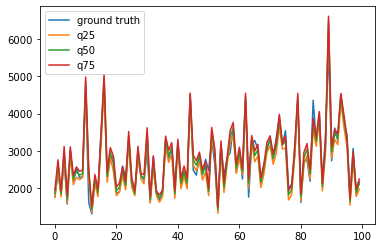

In [64]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [65]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

89.02789821370115 235.9036459825568 478.38232384225296 1.0


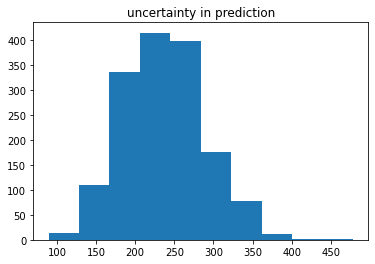

In [66]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

### PREDICTION

In [67]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,Percent_base,base_Age,typical_FVC,typical_Sex,typical_Smoking,age,BASE,week,pred_rf
1540,ID00419637202311204720264,-12,NaN,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,6.0,3020.0,-18.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.067901,1
1541,ID00419637202311204720264,-11,NaN,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,6.0,3020.0,-17.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.074074,1
1542,ID00419637202311204720264,-10,NaN,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,6.0,3020.0,-16.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.080247,1
1543,ID00419637202311204720264,-9,NaN,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,6.0,3020.0,-15.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.086420,1
1544,ID00419637202311204720264,-8,NaN,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,6.0,3020.0,-14.0,1,0,1,0,0,0.368718,0.686298,0.986459,0.244706,73,0.813374,1.0,1.0,0.615385,0.3724,0.092593,1


In [68]:
tr["delta_hugo"] = tr["FVC"]-tr["FVC_pred"]
tr.delta_hugo.describe()

count    1535.000000
mean      -26.517606
std       213.525504
min     -1074.748660
25%      -122.984294
50%        -7.946545
75%        87.613290
max       797.859710
Name: delta_hugo, dtype: float64

In [69]:
sub['FVC1'] = 0.994*pred_test_2_ave

# ensemble with lgb
sub["Confidence1"] = (pe[:, 2] - pe[:, 0]) * 0.5 + conf_predictions * 0.5

In [70]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [71]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,NaN,100.0,3017.976852,182.962883
1541,ID00419637202311204720264_-11,NaN,100.0,3014.536243,183.821099
1542,ID00419637202311204720264_-10,NaN,100.0,3011.096338,184.679085
1543,ID00419637202311204720264_-9,NaN,100.0,3007.656312,185.537056
1544,ID00419637202311204720264_-8,NaN,100.0,3004.216456,186.395119
1545,ID00419637202311204720264_-7,NaN,100.0,3000.776575,187.253029
1546,ID00419637202311204720264_-6,NaN,100.0,2997.336549,188.111046
1547,ID00419637202311204720264_-5,NaN,100.0,2993.896644,188.969078
1548,ID00419637202311204720264_-4,NaN,100.0,2990.456642,189.827187
1549,ID00419637202311204720264_-3,NaN,100.0,2987.016785,190.685127


In [72]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt_ens
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [73]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3017.976852,182.962883,3017.976852,182.962883
1541,ID00419637202311204720264_-11,3014.536243,183.821099,3014.536243,183.821099
1542,ID00419637202311204720264_-10,3011.096338,184.679085,3011.096338,184.679085
1543,ID00419637202311204720264_-9,3007.656312,185.537056,3007.656312,185.537056
1544,ID00419637202311204720264_-8,3004.216456,186.395119,3004.216456,186.395119


In [74]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2574.762376,421.745766,1701.596113,2450.376987,2664.225355,2846.955216,3314.324350
Confidence,730.0,266.081434,49.299851,166.507576,234.001407,278.699114,295.523698,352.325022
FVC1,730.0,2574.762376,421.745766,1701.596113,2450.376987,2664.225355,2846.955216,3314.324350
Confidence1,730.0,266.081434,49.299851,166.507576,234.001407,278.699114,295.523698,352.325022


In [75]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [76]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [77]:
subm.head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3017.976852,182.962883,3017.976852,182.962883
1541,ID00419637202311204720264_-11,3014.536243,183.821099,3014.536243,183.821099
1542,ID00419637202311204720264_-10,3011.096338,184.679085,3011.096338,184.679085
1543,ID00419637202311204720264_-9,3007.656312,185.537056,3007.656312,185.537056
1544,ID00419637202311204720264_-8,3004.216456,186.395119,3004.216456,186.395119
1545,ID00419637202311204720264_-7,3000.776575,187.253029,3000.776575,187.253029
1546,ID00419637202311204720264_-6,2997.336549,188.111046,2997.336549,188.111046
1547,ID00419637202311204720264_-5,2993.896644,188.969078,2993.896644,188.969078
1548,ID00419637202311204720264_-4,2990.456642,189.827187,2990.456642,189.827187
1549,ID00419637202311204720264_-3,2987.016785,190.685127,2987.016785,190.685127


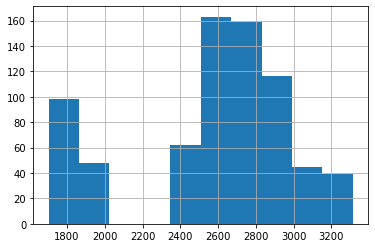

In [78]:
subm.FVC.hist()

In [79]:
train_x_2_new.head(5)

,pred_1a,pred_1b,pred_1c,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,age,Percent_base,week,BASE,typical_FVC,typical_Sex,typical_Smoking,pred_rf
0,2330.042480,2329.085112,2389.000000,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.179012,0.241456,0.714466,1.0,1.0,0
1,2298.786865,2312.860681,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.234568,0.241456,0.714466,1.0,1.0,0
2,2292.128418,2292.416121,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.246914,0.241456,0.714466,1.0,1.0,0
3,2285.470215,2294.514530,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.259259,0.241456,0.714466,1.0,1.0,0
4,2278.811279,2285.662293,2399.428571,1,0,1,0,0,0.368718,0.686298,0.986459,0.769231,0.135886,0.271605,0.241456,0.714466,1.0,1.0,0


In [80]:
test_x_2_new.head(20)

,pred_1a,pred_1b,pred_1c,Male,Female,Ex-smoker,Never smoked,Currently smokes,FVC_per_smoking,FVC_per_sex_smoking,FVC_std_per_sex_smoking,age,Percent_base,week,BASE,typical_FVC,typical_Sex,typical_Smoking,pred_rf
0,3065.321625,2919.683581,2909.047619,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.067901,0.3724,0.813374,1.0,1.0,1
1,3060.994904,2919.683581,2893.095238,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.074074,0.3724,0.813374,1.0,1.0,1
2,3056.669067,2919.683581,2893.095238,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.080247,0.3724,0.813374,1.0,1.0,1
3,3052.343079,2919.683581,2893.095238,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.086420,0.3724,0.813374,1.0,1.0,1
4,3048.017303,2919.683581,2893.095238,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.092593,0.3724,0.813374,1.0,1.0,1
5,3043.691498,2919.683581,2893.095238,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.098765,0.3724,0.813374,1.0,1.0,1
6,3039.365509,2919.683581,2893.095238,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.104938,0.3724,0.813374,1.0,1.0,1
7,3035.039673,2919.683581,2894.285714,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.111111,0.3724,0.813374,1.0,1.0,1
8,3030.713715,2919.683581,2894.285714,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.117284,0.3724,0.813374,1.0,1.0,1
9,3026.387939,2919.683581,2894.285714,1,0,1,0,0,0.368718,0.686298,0.986459,0.615385,0.244706,0.123457,0.3724,0.813374,1.0,1.0,1


In [81]:
print(tr[tr.cluster==0].delta.mean())
print(tr[tr.cluster==1].delta.mean())
print(tr[tr.cluster==2].delta.mean())

149.68355147502257
149.73636201839227
nan
